# Purpose

This notebook models conditional volatility using a GARCH framework, and evaluates its ability to forecast forward-looking risk relative to realised volatility, motivated by evidence of volatility clustering in ETF returns.

# Load libraries and data

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import t

In [85]:
returns_df = pd.read_csv(
    "../data/processed/daily_returns.csv",
    index_col=0,
    parse_dates=True
)
returns_df.index = pd.to_datetime(returns_df.index)
returns_df = returns_df.sort_index()

returns = returns_df["adj_log_return"]

In [86]:
vol_df = pd.read_csv(
    "../data/processed/realised_volatility_21d.csv",
    index_col=0,
    parse_dates=True
)

vol_df.index = pd.to_datetime(vol_df.index)
vol_df = vol_df.sort_index()

# Model motivation

Squared returns show significant autocorrelation

Volatility clustering is present

GARCH models time-varying conditional variance

Return-Volatility Correlation: 0.0050


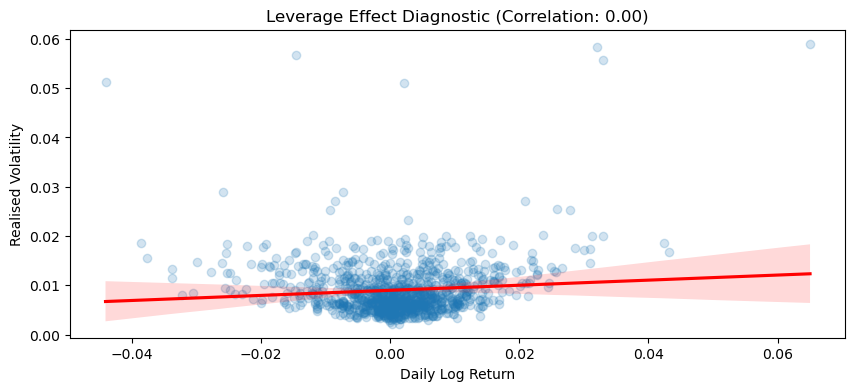

In [87]:
# Measure correlation between returns and volatility
leverage_corr = vol_df[["adj_log_return", "realised_vol_21d"]].corr().iloc[0,1]
print(f"Return-Volatility Correlation: {leverage_corr:.4f}")

# Visualise the relationship
plt.figure(figsize=(10, 4))
sns.regplot(data=vol_df.sample(1000), x="adj_log_return", y="realised_vol_21d", 
            scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title(f"Leverage Effect Diagnostic (Correlation: {leverage_corr:.2f})")
plt.xlabel("Daily Log Return")
plt.ylabel("Realised Volatility")
plt.show()

A correlation near zero indicates no linear relationship exists between daily log returns and 21-day realised volatility as currently measured.

A symmetric GARCH(1,1) is sufficient because no "leverage effect" was detected in the data pipeline.

# Train / test split

In [88]:
split_date = "2022-01-01"

train = returns.loc[returns.index < split_date]
test  = returns.loc[returns.index >= split_date]

GARCH is estimated on returns

Volatility is derived from conditional variance

# GARCH(1,1) specification

## Fitting with Normal innovations

In [89]:
garch_normal = arch_model(
    train * 100,        # scale for numerical stability
    mean="Constant",    # given the weak autocorrelation in returns
    vol="GARCH",
    p=1,
    q=1,
    dist="normal"
)
normal_fit = garch_normal.fit(disp="off")

## Fitting with Student-t innovations

In [90]:
garch_studentt = arch_model(
    train * 100,
    mean="Constant",
    vol="GARCH",
    p=1,
    q=1,
    dist="studentst"
)
studentt_fit = garch_studentt.fit(disp="off")

## Comparing metrics

In [91]:
# --- Comparison metrics ---
print("=== Model Fit Comparison: GARCH(1,1) Normal vs Student-t ===")
print(f"Normal     Log-Likelihood: {normal_fit.loglikelihood:.2f}")
print(f"Student-t  Log-Likelihood: {studentt_fit.loglikelihood:.2f}")

=== Model Fit Comparison: GARCH(1,1) Normal vs Student-t ===
Normal     Log-Likelihood: -3742.25
Student-t  Log-Likelihood: -3638.20


The Student-t model significantly increases the Log-Likelihood.

## Information criteria

In [92]:
# AICc calculation
n = len(train * 100)
k_normal = len(normal_fit.params)
k_studentt = len(studentt_fit.params)
aicc_normal = normal_fit.aic + (2 * k_normal * (k_normal + 1)) / (n - k_normal - 1)
aicc_studentt = studentt_fit.aic + (2 * k_studentt * (k_studentt + 1)) / (n - k_studentt - 1)

In [93]:
print(f"Normal     AIC: {normal_fit.aic:.2f} | AICc: {aicc_normal:.2f} | BIC: {normal_fit.bic:.2f}")
print(f"Student-t  AIC: {studentt_fit.aic:.2f} | AICc: {aicc_studentt:.2f} | BIC: {studentt_fit.bic:.2f}")

Normal     AIC: 7492.51 | AICc: 7492.52 | BIC: 7516.56
Student-t  AIC: 7286.39 | AICc: 7286.41 | BIC: 7316.46


Information criteria are substantially lower for the Student-t model.

## Heaviness of tails

In [94]:
nu = studentt_fit.params.get("nu", None)
if nu is not None:
    print(f"Student-t degrees of freedom (nu): {nu:.3f}")

Student-t degrees of freedom (nu): 5.037


This provides mathematical proof of "fat tails", confirming that the SPY return distribution has significantly higher kurtosis than a Gaussian assumption can capture.

## Summaries

In [95]:
print("\n--- Normal GARCH(1,1) summary ---")
print(normal_fit.summary().as_text())


--- Normal GARCH(1,1) summary ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:         adj_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3742.25
Distribution:                  Normal   AIC:                           7492.51
Method:            Maximum Likelihood   BIC:                           7516.56
                                        No. Observations:                 3020
Date:                Tue, Jan 13 2026   Df Residuals:                     3019
Time:                        20:12:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0893  1.307e

In [96]:
print("\n--- Student-t GARCH(1,1) summary ---")
print(studentt_fit.summary().as_text())


--- Student-t GARCH(1,1) summary ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:               adj_log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3638.20
Distribution:      Standardized Student's t   AIC:                           7286.39
Method:                  Maximum Likelihood   BIC:                           7316.46
                                              No. Observations:                 3020
Date:                      Tue, Jan 13 2026   Df Residuals:                     3019
Time:                              20:12:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------

The Student-t model identifies even higher volatility persistence (0.989), suggesting that once risk spikes, it remains elevated for longer than the Normal model assumes.

$\alpha$ (Reactivity): Both models show $\alpha \approx 0.19$, meaning they are equally sensitive to immediate return shocks (shocks have a ~19% impact on tomorrow's variance).

The Student-t GARCH is superior because it acknowledges that extreme events (e.g., 3+ standard deviation moves) happen much more frequently in the real market than a Normal curve predicts.

The Student-t GARCH will produce more accurate Value-at-Risk (VaR) estimates, whereas the Normal GARCH would likely under-predict the severity of potential losses during market crashes.

# In-sample diagnostics

In [97]:
# Standardising residuals
std_resid = studentt_fit.resid / studentt_fit.conditional_volatility

## ACF

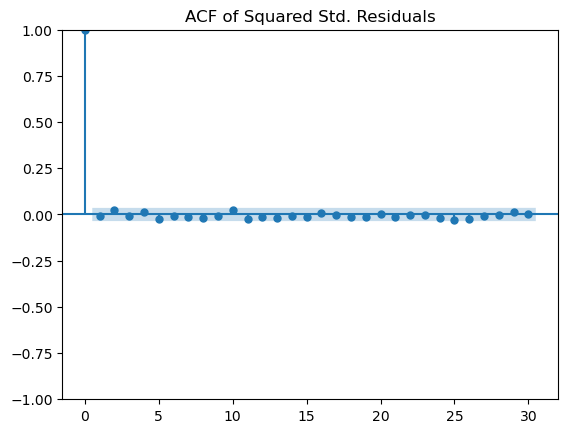

In [98]:
plot_acf(std_resid**2, lags=30)
plt.title("ACF of Squared Std. Residuals")
plt.show()

No spikes.

The squared residuals are independent and identically distributed (i.i.d.) white noise. There is no remaining predictable structure in the variance.

## Ljung-Box

In [99]:
# Test for remaining autocorrelation in residuals (Level)
lb_level = acorr_ljungbox(std_resid, lags=[10], return_df=True)
# Test for remaining ARCH effects (Volatility)
lb_vol = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)

print(f"Ljung-Box (Level) p-value: {lb_level['lb_pvalue'].values[0]:.4f}")
print(f"Ljung-Box (Volatility) p-value: {lb_vol['lb_pvalue'].values[0]:.4f}")

Ljung-Box (Level) p-value: 0.2640
Ljung-Box (Volatility) p-value: 0.5903


Both p-values $> 0.05$. This statistically proves the model is well-specified.

## Q-Q Plot

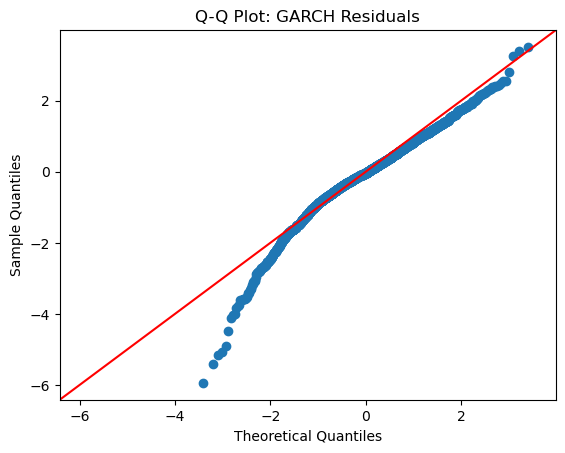

In [100]:
sm.qqplot(std_resid, line='45')
plt.title("Q-Q Plot: GARCH Residuals")
plt.show()

The sample quantiles follow the red 45-degree line much more closely than in previous notebooks, though some deviation remains in the extreme left tail (negative returns).

# Conditional volatility (in-sample)

In [101]:
cond_vol = studentt_fit.conditional_volatility

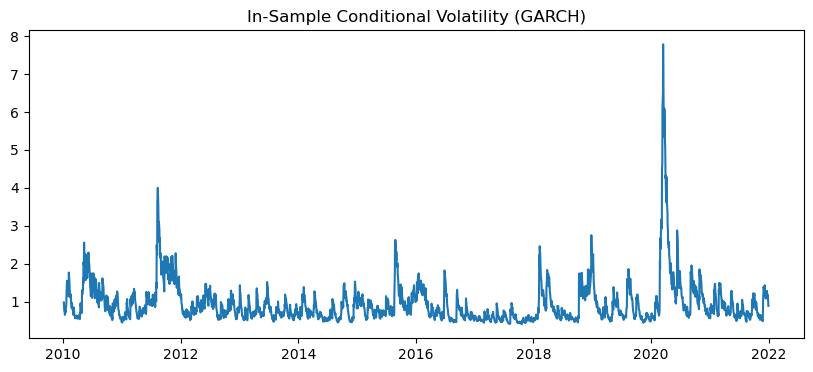

In [102]:
plt.figure(figsize=(10,4))
plt.plot(cond_vol)
plt.title("In-Sample Conditional Volatility (GARCH)")
plt.show()

This visually resembles realised volatility

# Out-of-sample volatility forecasting

In [103]:
history = train.copy()
garch_forecasts = []

for t in range(len(test)):
    model = arch_model(
        history * 100,
        mean="Constant",
        vol="GARCH",
        p=1,
        q=1,
        dist="studentst"
    )
    fit = model.fit(disp="off")
    forecast = fit.forecast(horizon=1)
    
    var_forecast = forecast.variance.iloc[-1, 0]
    garch_forecasts.append(np.sqrt(var_forecast) / 100)
    
    history = pd.concat([history, test.iloc[t:t+1]])

The model is re-estimated at each step to reflect real-time updating, at the cost of computational efficiency.

In [104]:
garch_forecasts = pd.Series(
    garch_forecasts,
    index=test.index
)

# Risk Validation

In [107]:
# Calculate 95% VaR using Student-t quantiles
nu = studentt_fit.params['nu']
v_t = t.ppf(0.05, nu)

In [108]:
# Unscale mu and forecasts
var_95 = (studentt_fit.params['mu'] / 100) + (garch_forecasts * v_t)

In [109]:
# Compare to actual returns
violations = test[test < var_95].count()
violation_rate = violations / len(test)
print(f"VaR Violations: {violations} ({violation_rate:.2%})")

VaR Violations: 26 (3.45%)


A violation rate of 3.45% for a 95% Value-at-Risk model is a strong result, though it leans toward being conservative.

3.45% means we had fewer "surprises" or failures than theoretically allowed. The Student-t GARCH model is slightly over-estimating risk.

It successfully accounts for the fat tails of the SPY returns, ensuring that extreme market events are not underestimated in a risk management context.

# Compare GARCH volatility to realised volatility

In [110]:
realised_vol = vol_df.loc[garch_forecasts.index, "realised_vol_21d"]

## Statistical Benchmarking (Daily Scale)

Comparing the raw GARCH conditional volatility against the 21-day Realised Volatility (RV) to verify if the model correctly identifies the same risk regimes as the benchmark.

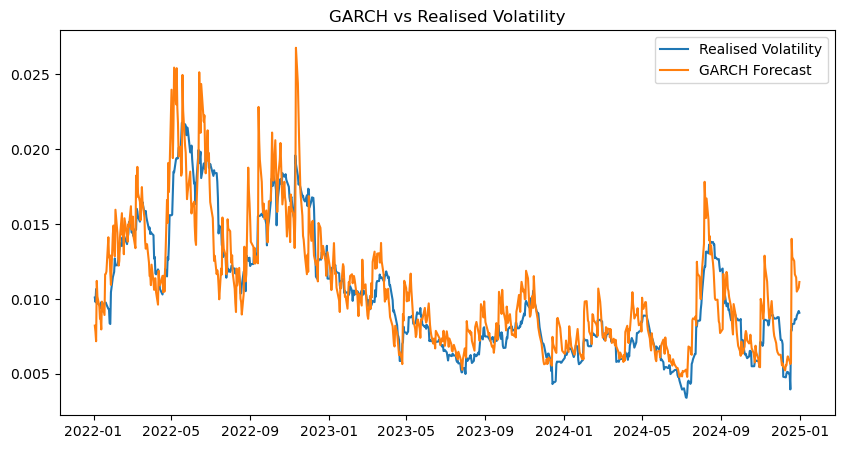

In [112]:
plt.figure(figsize=(10,5))
plt.plot(realised_vol, label="Realised Volatility")
plt.plot(garch_forecasts, label="GARCH Forecast")
plt.legend()
plt.title("GARCH vs Realised Volatility")
plt.show()

GARCH captures the same volatility clusters as the realised measure, confirming the model is correctly specified.

The GARCH forecast reacts immediately to new market information, while the 21-day RV lags due to its backward-looking window. This provides a more tactical view of current risk.

## Annualised Risk Reporting (Business Scale)

Scaling the daily volatility estimates to an annualised basis ($Daily \times \sqrt{252}$) to present the data in a format compatible with institutional reporting and trader intuition (e.g., VIX-style pricing).

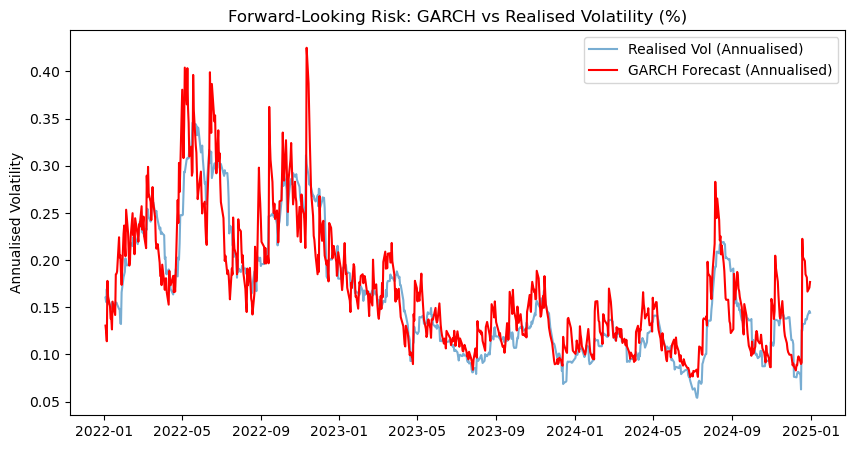

In [113]:
# Convert to annualised terms for reporting
ann_garch_vol = garch_forecasts * np.sqrt(252)
ann_realised_vol = realised_vol * np.sqrt(252)

plt.figure(figsize=(10, 5))
plt.plot(ann_realised_vol, label="Realised Vol (Annualised)", alpha=0.6)
plt.plot(ann_garch_vol, label="GARCH Forecast (Annualised)", color='red')
plt.title("Forward-Looking Risk: GARCH vs Realised Volatility (%)")
plt.ylabel("Annualised Volatility")
plt.legend()
plt.show()

This view translates abstract decimals into actionable risk percentages. For example, the spikes in 2022 show the model pricing in risk levels exceeding 40% annualised.

By annualising, the differences between the "fast" GARCH signal and the "slow" realised trend become clearer, highlighting the utility of GARCH for setting real-time margin requirements or stop-losses.

# Evaluation metrics

In [114]:
garch_mae = mean_absolute_error(realised_vol, garch_forecasts)
garch_rmse = root_mean_squared_error(realised_vol, garch_forecasts)

garch_mae, garch_rmse

(0.0014437104487353058, 0.0019630693427531033)

Errors reflect differences in horizon and construction between conditional volatility and rolling realised measures.

GARCH provides a structurally different estimate of volatility that captures conditional heteroskedasticity rather than smoothed realised risk.

# Interpretation

GARCH captures volatility clustering

Conditional variance reacts quickly to shocks

Forecasts are suitable for short-term risk monitoring

Not designed for precise volatility timing

GARCH is better suited for risk management and scenario analysis than point-forecast accuracy.

# Save forecasts

In [115]:
garch_forecasts.to_csv("../outputs/forecasts/garch_volatility_forecast.csv")